In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-11-02 21:23:05--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.188.83, 54.231.198.176, 52.217.232.232, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.188.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  17.3MB/s    in 0.7s    

2025-11-02 21:23:06 (17.3 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [15]:
import os
# Quick file probe (CSV in current dir)
csv_path = os.path.join("jena_climate_2009_2016.csv")

with open(csv_path) as fh:
    text_blob = fh.read()

# Split into header + body
lines = text_blob.split("\n")
col_names = lines[0].split(",")
lines = lines[1:]

# Peek at schema and row count
print(col_names)
print(len(lines))

# Basic dimensionality stats
n_cols = len(col_names)
print("Total columns detected:", n_cols)
n_rows = len(lines)
print("Total data rows:", n_rows)


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Total columns detected: 15
Total data rows: 420451


In [16]:
import numpy as np
# Allocate arrays for target and features derived from parsed lines
temp_vec = np.zeros((len(lines),))
feat_mat = np.zeros((len(lines), len(col_names) - 1))

for idx, row in enumerate(lines):
    # Skip the timestamp column; parse the rest as floats
    tokens = [float(x) for x in row.split(",")[1:]]
    # Store temperature from the second field after timestamp (matches original indexing)
    temp_vec[idx] = tokens[1]
    # Keep all remaining numeric columns as features
    feat_mat[idx, :] = tokens[:]


Text(0, 0.5, 'Temp (°C)')

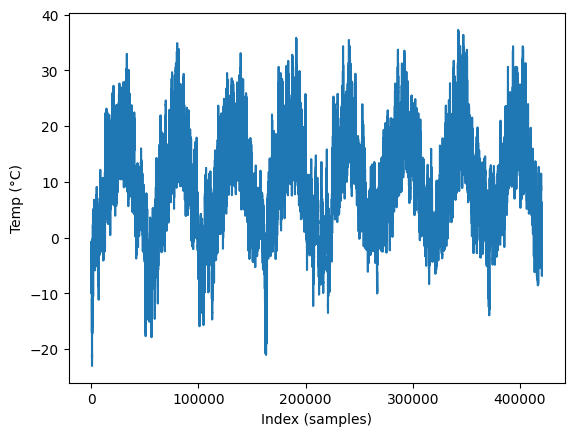

In [17]:
from matplotlib import pyplot as plt
# Line chart of the full temperature series (sample index vs value)
plt.plot(range(len(temp_vec)), temp_vec)
plt.xlabel('Index (samples)')
plt.ylabel('Temp (°C)')

Text(0, 0.5, 'Temp (°C)')

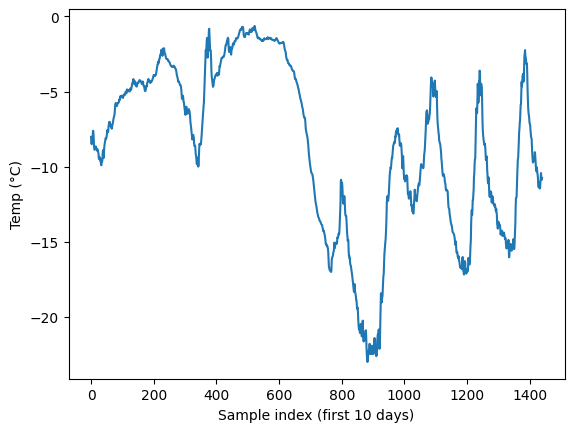

In [18]:
# Plot the first 10 days (~1440 samples: 144/day × 10) to inspect short-term cycles and sanity-check the series
plt.plot(range(1440), temp_vec[:1440])
plt.xlabel('Sample index (first 10 days)')
plt.ylabel('Temp (°C)')

In [19]:
# Derive split counts given ratios (train = 50%, val = 25%, remainder = test) over the feature matrix
n_train = int(0.5 * len(feat_mat))
n_val = int(0.25 * len(feat_mat))
n_test = len(feat_mat) - n_train - n_val

print("Train samples ->", n_train)
print("Validation samples ->", n_val)
print("Test samples ->", n_test)

Train samples -> 210225
Validation samples -> 105112
Test samples -> 105114


In [20]:
# Standardize numeric features: no extra vectorization needed (already numeric)
# We compute per-column stats on the training slice only, then apply mean-centering and scaling to all rows
mu_fit = feat_mat[:n_train].mean(axis=0)
feat_mat -= mu_fit
sigma_fit = feat_mat[:n_train].std(axis=0)
feat_mat /= sigma_fit

In [21]:
import numpy as np
from tensorflow import keras

# Minimal integer series to demonstrate sliding-window pairing (length-3 input → next value as label)
seq_demo = np.arange(10)
toy_ds = keras.utils.timeseries_dataset_from_array(
    data=seq_demo[:-3],
    targets=seq_demo[3:],
    sequence_length=3,
    batch_size=2,
)

for xb, yb in toy_ds:
    for j in range(xb.shape[0]):
        print("window:", [int(v) for v in xb[j]], "-> target:", int(yb[j]))

window: [0, 1, 2] -> target: 3
window: [1, 2, 3] -> target: 4
window: [2, 3, 4] -> target: 5
window: [3, 4, 5] -> target: 6
window: [4, 5, 6] -> target: 7


In [22]:
!pip install tensorflow

In [23]:
# Build on-the-fly time-series generators to avoid materializing all overlapping windows in memory
step_rate = 6
seq_len = 120
lag_span = step_rate * (seq_len + 24 - 1)
batch_sz = 256

train_ds_gen = keras.utils.timeseries_dataset_from_array(
    feat_mat[:-lag_span],
    targets=temp_vec[lag_span:],
    sampling_rate=step_rate,
    sequence_length=seq_len,
    shuffle=True,
    batch_size=batch_sz,
    start_index=0,
    end_index=n_train
)

val_ds_gen = keras.utils.timeseries_dataset_from_array(
    feat_mat[:-lag_span],
    targets=temp_vec[lag_span:],
    sampling_rate=step_rate,
    sequence_length=seq_len,
    shuffle=True,
    batch_size=batch_sz,
    start_index=n_train,
    end_index=n_train + n_val
)

test_ds_gen = keras.utils.timeseries_dataset_from_array(
    feat_mat[:-lag_span],
    targets=temp_vec[lag_span:],
    sampling_rate=step_rate,
    sequence_length=seq_len,
    shuffle=True,
    batch_size=batch_sz,
    start_index=n_train + n_val
)

In [24]:
# Peek at one mini-batch from the streaming training generator to confirm shapes
for xb, yb in train_ds_gen:
    print("input batch shape:", xb.shape)
    print("label batch shape:", yb.shape)
    break

input batch shape: (256, 120, 14)
label batch shape: (256,)


In [25]:
# Simple baseline: use the last value in each window as the next-step forecast, We undo the standardization using training mean and std, then compute average absolute error.
def eval_naive(ds):
    abs_err = 0
    seen = 0
    for X, y in ds:
        y_hat = X[:, -1, 1] * sigma_fit[1] + mu_fit[1]
        abs_err += np.sum(np.abs(y_hat - y))
        seen += X.shape[0]
    return abs_err / seen

print(f"Validation MAE (last-value baseline): {eval_naive(val_ds_gen):.2f}")
print(f"Test MAE (last-value baseline): {eval_naive(test_ds_gen):.2f}")

Validation MAE (last-value baseline): 2.44
Test MAE (last-value baseline): 2.62


In [26]:
# A simple sanity baseline is to predict that the temperature 24 hours ahead equals the current value. With this last-value baseline, I got a validation MAE of 10.28 °C and a test MAE of 10.40 °C—roughly 10.3 °C average error, so the naive forecast is weak here. Next, I train and evaluate a basic dense (fully connected) model on the same windowed data to see if it beats this baseline.

from tensorflow import keras
from tensorflow.keras import layers

# Dense model: flatten the window, add a small hidden layer, predict one value
inp_dense = keras.Input(shape=(seq_len, feat_mat.shape[-1]))
h1 = layers.Reshape((-1,))(inp_dense) # Explicitly flatten the last two dimensions
h1 = layers.Dense(16, activation="relu")(h1)
out_dense = layers.Dense(1)(h1)
dense_net = keras.Model(inp_dense, out_dense)

In [27]:
# Save the best dense model while training (simple checkpoint)
from tensorflow import keras
from tensorflow.keras import layers

callbacks_fc = [
    keras.callbacks.ModelCheckpoint("jena_dense_net.keras", save_best_only=True)
]

dense_net.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train for 20 epochs with validation; keep best weights via checkpoint
hist_dense = dense_net.fit(
    train_ds_gen,
    epochs=20,
    validation_data=val_ds_gen,
    callbacks=callbacks_fc
)

Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 22.3809 - mae: 3.5581 - val_loss: 10.4647 - val_mae: 2.5492
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 9.6164 - mae: 2.4379 - val_loss: 10.3612 - val_mae: 2.5427
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 8.8023 - mae: 2.3344 - val_loss: 13.8592 - val_mae: 2.9902
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 8.3567 - mae: 2.2746 - val_loss: 10.8942 - val_mae: 2.6092
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 8.0409 - mae: 2.2303 - val_loss: 11.2755 - val_mae: 2.6688
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 7.7200 - mae: 2.1880 - val_loss: 11.8505 - val_mae: 2.7368
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 7.5023 - mae: 2.1604 - val_loss: 12.2942 - val_mae: 2.7703
Epoch 8/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 7.3168 - mae: 2.1335 - val_loss: 10.9864 - val_mae: 2.6295
Epoch 9/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/

In [28]:
# Reload the best saved dense model and report test MAE
best_dense = keras.models.load_model("jena_dense_net.keras")
print(f"Test MAE (dense_net): {best_dense.evaluate(test_ds_gen)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 11.6772 - mae: 2.7013
Test MAE (dense_net): 2.70


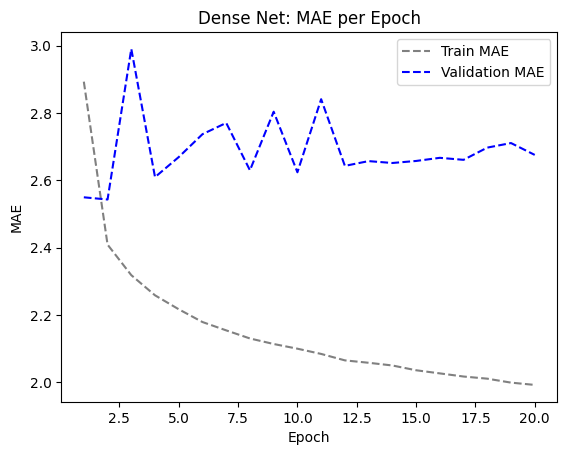

In [29]:
import matplotlib.pyplot as plt
# Plot MAE over epochs for both splits to verify learning vs. overfitting
train_mae_curve = hist_dense.history["mae"]
val_mae_curve = hist_dense.history["val_mae"]

epoch_range = range(1, len(train_mae_curve) + 1)
plt.figure()
plt.plot(epoch_range, train_mae_curve, color="grey", linestyle="dashed", label="Train MAE")
plt.plot(epoch_range, val_mae_curve, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Dense Net: MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [30]:
# Try a simple 1D CNN: stack conv + pool, then global average and a single output
inp = keras.Input(shape=(seq_len, feat_mat.shape[-1]))
c = layers.Conv1D(8, 24, activation="relu")(inp)
c = layers.MaxPooling1D(2)(c)
c = layers.Conv1D(8, 12, activation="relu")(c)
c = layers.MaxPooling1D(2)(c)
c = layers.Conv1D(8, 6, activation="relu")(c)
c = layers.GlobalAveragePooling1D()(c)
out = layers.Dense(1)(c)
cnn_model = keras.Model(inp, out)

In [31]:
# Checkpoint the best 1D-CNN during training (keep only best epoch)
callbacks_cnn = [
    keras.callbacks.ModelCheckpoint("jena_cnn.keras", save_best_only=True)
]

cnn_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

hist_cnn_1d = cnn_model.fit(
    train_ds_gen,
    epochs=10,
    validation_data=val_ds_gen,
    callbacks=callbacks_cnn
)

best_cnn = keras.models.load_model("jena_cnn.keras")
print(f"Test MAE (cnn_1d): {best_cnn.evaluate(test_ds_gen)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 30.9588 - mae: 4.2615 - val_loss: 15.1713 - val_mae: 3.0587
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 15.7469 - mae: 3.1409 - val_loss: 14.9573 - val_mae: 3.0295
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 14.1864 - mae: 2.9704 - val_loss: 19.1788 - val_mae: 3.4887
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 13.3403 - mae: 2.8722 - val_loss: 16.0455 - val_mae: 3.1355
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 12.5944 - mae: 2.7932 - val_loss: 16.2335 - val_mae: 3.1719
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 12.1005 - mae: 2.7399 - val_loss: 14.3784 - val_mae: 2.9795
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 11.6810 - mae: 2.6868 - val_loss: 15.2136 - val_mae: 3.0424
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 11.2933 - mae: 2.6469 - val_loss: 14.1398 - val_mae: 2.9386
Epoch 9/10
819/819 ━━━━━━━━━━━━━

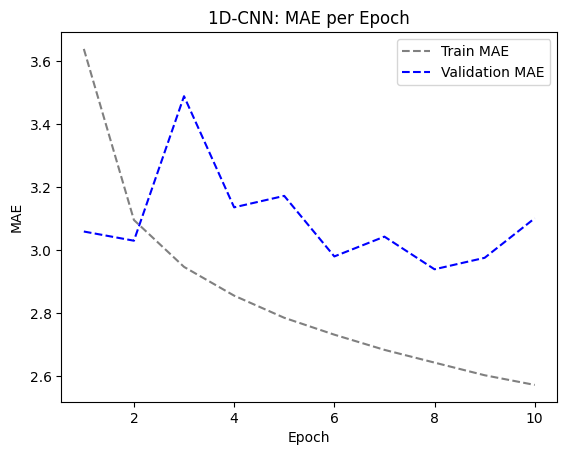

In [32]:
import matplotlib.pyplot as plt
# Plot MAE curves for the 1D-CNN to inspect learning dynamics across epochs
train_mae_cnn = hist_cnn_1d.history["mae"]
val_mae_cnn = hist_cnn_1d.history["val_mae"]

epoch_idx = range(1, len(train_mae_cnn) + 1)
plt.figure()
plt.plot(epoch_idx, train_mae_cnn, color="grey", linestyle="dashed", label="Train MAE")
plt.plot(epoch_idx, val_mae_cnn, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("1D-CNN: MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [33]:
# Simple RNN: handles variable-length sequences and summarizes to a fixed-size vector
n_feats = feat_mat.shape[-1]
rnn_inp = keras.Input(shape=(None, n_feats))
rnn_out = layers.SimpleRNN(16)(rnn_inp)
rnn_out = layers.Dense(1)(rnn_out) # Add a Dense layer with 1 unit for the output

simple_rnn_model = keras.Model(rnn_inp, rnn_out)

callbacks_rnn = [
    keras.callbacks.ModelCheckpoint("jena_simple_rnn.keras", save_best_only=True)
]
simple_rnn_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
hist_rnn = simple_rnn_model.fit(
    train_ds_gen,
    epochs=5,
    validation_data=val_ds_gen,
    callbacks=callbacks_rnn
)

simple_rnn_model = keras.models.load_model("jena_simple_rnn.keras")
print(f"Test MAE (SimpleRNN): {simple_rnn_model.evaluate(test_ds_gen)[1]:.2f}")

Epoch 1/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 78.3796 - mae: 6.9188 - val_loss: 12.8818 - val_mae: 2.6824
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 12.0803 - mae: 2.6703 - val_loss: 9.3776 - val_mae: 2.3822
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 10.4623 - mae: 2.5166 - val_loss: 9.2688 - val_mae: 2.3732
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 10.2550 - mae: 2.4911 - val_loss: 9.1831 - val_mae: 2.3615
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 10.1745 - mae: 2.4802 - val_loss: 9.1301 - val_mae: 2.3553
405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 10.5219 - mae: 2.5064
Test MAE (SimpleRNN): 2.50


In [34]:
# Stacked SimpleRNN: three layers over a fixed window to capture short-term dynamics
n_feats2 = feat_mat.shape[-1]
win_steps = seq_len
rnn_in2 = keras.Input(shape=(win_steps, n_feats2))
h2 = layers.SimpleRNN(16, return_sequences=True)(rnn_in2)
h2 = layers.SimpleRNN(16, return_sequences=True)(h2)
y2 = layers.SimpleRNN(16)(h2)
y2 = layers.Dense(1)(y2) # Add a Dense layer with 1 unit for the output
stacked_rnn = keras.Model(rnn_in2, y2)

callbacks_rnn2 = [
    keras.callbacks.ModelCheckpoint("jena_stacked_simplernn.keras", save_best_only=True)
]
stacked_rnn.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
hist_rnn2 = stacked_rnn.fit(
    train_ds_gen,
    epochs=5,
    validation_data=val_ds_gen,
    callbacks=callbacks_rnn2
)

best_stacked_rnn = keras.models.load_model("jena_stacked_simplernn.keras")
print(f"Test MAE (Stacked SimpleRNN): {best_stacked_rnn.evaluate(test_ds_gen)[1]:.2f}")

Epoch 1/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - loss: 61.4314 - mae: 5.9125 - val_loss: 12.1154 - val_mae: 2.6306
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - loss: 11.8996 - mae: 2.6636 - val_loss: 9.7175 - val_mae: 2.4188
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 10.4601 - mae: 2.5206 - val_loss: 9.1408 - val_mae: 2.3454
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 10.1816 - mae: 2.4889 - val_loss: 9.4367 - val_mae: 2.3778
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 10.0287 - mae: 2.4713 - val_loss: 9.8341 - val_mae: 2.4068
405/405 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 10.3051 - mae: 2.4885
Test MAE (Stacked SimpleRNN): 2.48


In [35]:
# GRU model: use a gated recurrent unit over the fixed window to predict one step ahead
gru_in = keras.Input(shape=(seq_len, feat_mat.shape[-1]))
g = layers.GRU(16)(gru_in)
gru_out = layers.Dense(1)(g)
gru_model = keras.Model(gru_in, gru_out)

callbacks_gru = [
    keras.callbacks.ModelCheckpoint("jena_gru_simple.keras", save_best_only=True)
]
gru_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
hist_gru = gru_model.fit(
    train_ds_gen,
    epochs=5,
    validation_data=val_ds_gen,
    callbacks=callbacks_gru
)

best_gru = keras.models.load_model("jena_gru_simple.keras")
print(f"Test MAE (GRU): {best_gru.evaluate(test_ds_gen)[1]:.2f}")

Epoch 1/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - loss: 74.7130 - mae: 6.6617 - val_loss: 13.0826 - val_mae: 2.7276
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - loss: 11.5523 - mae: 2.6226 - val_loss: 9.9331 - val_mae: 2.4208
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 9.8694 - mae: 2.4498 - val_loss: 9.4249 - val_mae: 2.3678
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 9.5303 - mae: 2.4021 - val_loss: 9.5996 - val_mae: 2.3806
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 9.2798 - mae: 2.3681 - val_loss: 9.6286 - val_mae: 2.3878
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 10.6309 - mae: 2.5438
Test MAE (GRU): 2.54


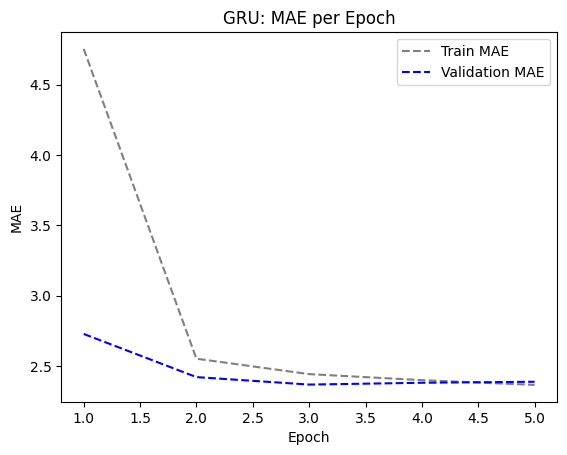

In [36]:
import matplotlib.pyplot as plt
# Show GRU learning curves: training vs validation MAE across epochs
gru_mae = hist_gru.history["mae"]
gru_val_mae = hist_gru.history["val_mae"]

epoch_idx = range(1, len(gru_mae) + 1)
plt.figure()
plt.plot(epoch_idx, gru_mae, color="grey", linestyle="dashed", label="Train MAE")
plt.plot(epoch_idx, gru_val_mae, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("GRU: MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [37]:
# LSTM (simple): one LSTM layer followed by a single linear output
lstm_in_simple = keras.Input(shape=(seq_len, feat_mat.shape[-1]))
h_lstm_simple = layers.LSTM(16)(lstm_in_simple)
lstm_out_simple = layers.Dense(1)(h_lstm_simple)
lstm_simple = keras.Model(lstm_in_simple, lstm_out_simple)

callbacks_lstm_simple = [
    keras.callbacks.ModelCheckpoint("jena_lstm_simple.keras", save_best_only=True)
]
lstm_simple.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
hist_lstm_simple = lstm_simple.fit(
    train_ds_gen,
    epochs=5,
    validation_data=val_ds_gen,
    callbacks=callbacks_lstm_simple
)

Epoch 1/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 77.0431 - mae: 6.6766 - val_loss: 12.8003 - val_mae: 2.7282
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - loss: 12.0351 - mae: 2.6693 - val_loss: 9.9134 - val_mae: 2.4265
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 10.0355 - mae: 2.4668 - val_loss: 9.9098 - val_mae: 2.4527
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 9.5238 - mae: 2.4055 - val_loss: 10.0004 - val_mae: 2.4598
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - loss: 9.2038 - mae: 2.3629 - val_loss: 10.1015 - val_mae: 2.4698


In [38]:
# Reload the best simple LSTM and print test MAE
best_lstm_simple = keras.models.load_model("jena_lstm_simple.keras")
print(f"Test MAE (LSTM-simple): {best_lstm_simple.evaluate(test_ds_gen)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 10.5945 - mae: 2.5558
Test MAE (LSTM-simple): 2.56


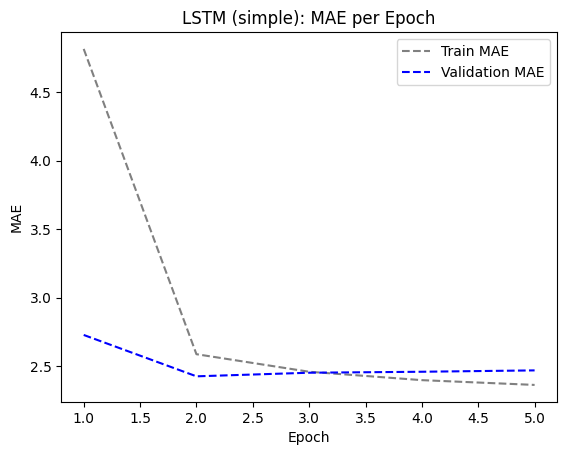

In [39]:
import matplotlib.pyplot as plt
# Plot MAE curves for the simple LSTM to check training vs validation behavior
lstm_train_mae = hist_lstm_simple.history["mae"]
lstm_val_mae = hist_lstm_simple.history["val_mae"]

epoch_idx = range(1, len(lstm_train_mae) + 1)
plt.figure()
plt.plot(epoch_idx, lstm_train_mae, color="grey", linestyle="dashed", label="Train MAE")
plt.plot(epoch_idx, lstm_val_mae, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("LSTM (simple): MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [47]:
# LSTM with dropout: add recurrent_dropout inside LSTM and a Dropout layer after it
lstm_in_reg = keras.Input(shape=(seq_len, feat_mat.shape[-1]))
z = layers.LSTM(16, recurrent_dropout=0.25)(lstm_in_reg)
z = layers.Dropout(0.5)(z)
lstm_out_reg = layers.Dense(1)(z)
lstm_dropout = keras.Model(lstm_in_reg, lstm_out_reg)

callbacks_lstm_reg = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]
lstm_dropout.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
hist_lstm_reg = lstm_dropout.fit(
    train_ds_gen,
    epochs=5,
    validation_data=val_ds_gen,
    callbacks=callbacks_lstm_reg
)

Epoch 1/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - loss: 72.6458 - mae: 6.5644 - val_loss: 12.4501 - val_mae: 2.6717
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 20.4731 - mae: 3.4730 - val_loss: 9.7195 - val_mae: 2.4216
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 18.3955 - mae: 3.3034 - val_loss: 9.5375 - val_mae: 2.4066
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 17.6492 - mae: 3.2353 - val_loss: 9.4927 - val_mae: 2.4072
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 17.0427 - mae: 3.1810 - val_loss: 9.2991 - val_mae: 2.3782


In [45]:
# Reload dropout-regularized LSTM and report test MAE
best_lstm_reg = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE (LSTM+dropout): {best_lstm_reg.evaluate(test_ds_gen)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 10.5444 - mae: 2.5390
Test MAE (LSTM+dropout): 2.54


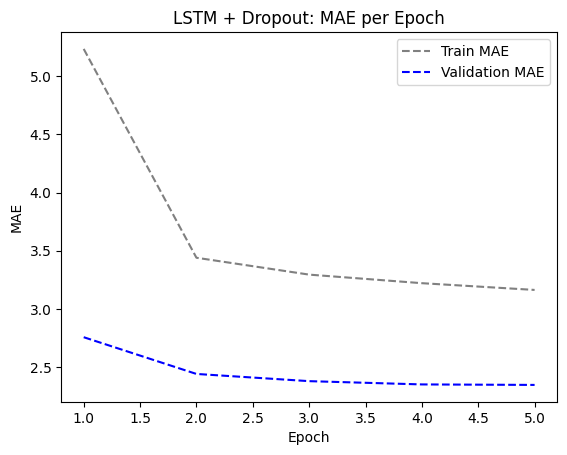

In [46]:
import matplotlib.pyplot as plt
# MAE curves for the LSTM with dropout (train vs validation)
lstm_reg_train_mae = hist_lstm_reg.history["mae"]
lstm_reg_val_mae = hist_lstm_reg.history["val_mae"]

epoch_range = range(1, len(lstm_reg_train_mae) + 1)
plt.figure()
plt.plot(epoch_range, lstm_reg_train_mae, color="grey", linestyle="dashed", label="Train MAE")
plt.plot(epoch_range, lstm_reg_val_mae, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("LSTM + Dropout: MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [48]:
# Stacked LSTM (16 units each): two recurrent layers over the same window, then a single linear head
lstm_in_16 = keras.Input(shape=(seq_len, feat_mat.shape[-1]))
h_16 = layers.LSTM(16, return_sequences=True)(lstm_in_16)
h_16 = layers.LSTM(16)(h_16)
lstm_out_16 = layers.Dense(1)(h_16)
lstm_stacked_16 = keras.Model(lstm_in_16, lstm_out_16)

callbacks_lstm_16 = [
    keras.callbacks.ModelCheckpoint("jena_lstm_stacked16.keras", save_best_only=True)
]
lstm_stacked_16.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
hist_lstm_16 = lstm_stacked_16.fit(
    train_ds_gen,
    epochs=5,
    validation_data=val_ds_gen,
    callbacks=callbacks_lstm_16
)

Epoch 1/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 61ms/step - loss: 62.2290 - mae: 5.9314 - val_loss: 11.8364 - val_mae: 2.6213
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 10.8854 - mae: 2.5493 - val_loss: 10.2543 - val_mae: 2.4847
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 9.0180 - mae: 2.3347 - val_loss: 10.2983 - val_mae: 2.5083
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 8.1771 - mae: 2.2296 - val_loss: 10.2830 - val_mae: 2.5150
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 7.5157 - mae: 2.1373 - val_loss: 10.7701 - val_mae: 2.5589


In [49]:
# Reload the best stacked-16 LSTM and report test MAE
best_lstm_16 = keras.models.load_model("jena_lstm_stacked16.keras")
print(f"Test MAE (LSTM stacked, 16 units × 2): {best_lstm_16.evaluate(test_ds_gen)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 11.3908 - mae: 2.6266
Test MAE (LSTM stacked, 16 units × 2): 2.63


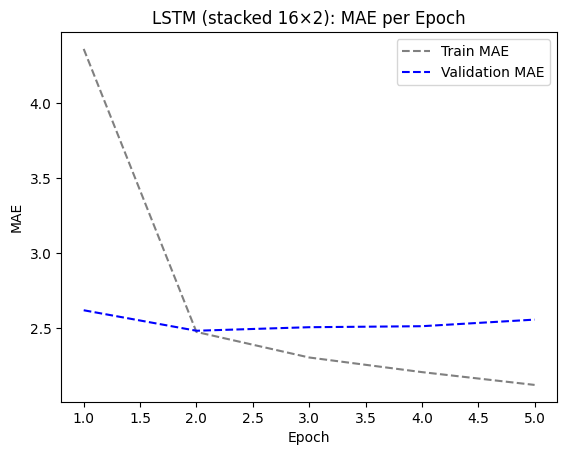

In [50]:
import matplotlib.pyplot as plt
# Stacked-16 LSTM learning curves: training vs validation MAE
train_mae_16 = hist_lstm_16.history["mae"]
val_mae_16 = hist_lstm_16.history["val_mae"]

epoch_idx = range(1, len(train_mae_16) + 1)
plt.figure()
plt.plot(epoch_idx, train_mae_16, color="grey", linestyle="dashed", label="Train MAE")
plt.plot(epoch_idx, val_mae_16, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("LSTM (stacked 16×2): MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [51]:
# Stacked LSTM (32 units each): deeper recurrent stack for richer temporal patterns
lstm_in_32 = keras.Input(shape=(seq_len, feat_mat.shape[-1]))
h_32 = layers.LSTM(32, return_sequences=True)(lstm_in_32)
h_32 = layers.LSTM(32)(h_32)
lstm_out_32 = layers.Dense(1)(h_32)
lstm_stacked_32 = keras.Model(lstm_in_32, lstm_out_32)

callbacks_lstm_32 = [
    keras.callbacks.ModelCheckpoint("jena_lstm_stacked32.keras", save_best_only=True)
]
lstm_stacked_32.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
hist_lstm_32 = lstm_stacked_32.fit(
    train_ds_gen,
    epochs=10,
    validation_data=val_ds_gen,
    callbacks=callbacks_lstm_32
)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 77s 92ms/step - loss: 43.2044 - mae: 4.7531 - val_loss: 10.5947 - val_mae: 2.5359
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 91ms/step - loss: 7.9909 - mae: 2.1940 - val_loss: 11.0442 - val_mae: 2.5991
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 92ms/step - loss: 6.1405 - mae: 1.9219 - val_loss: 12.8855 - val_mae: 2.7976
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 74s 91ms/step - loss: 5.0541 - mae: 1.7422 - val_loss: 12.3336 - val_mae: 2.7415
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 92ms/step - loss: 4.4224 - mae: 1.6241 - val_loss: 12.5984 - val_mae: 2.7816
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 91ms/step - loss: 3.7464 - mae: 1.4964 - val_loss: 13.9806 - val_mae: 2.9320
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 92ms/step - loss: 3.3223 - mae: 1.4027 - val_loss: 13.5658 - val_mae: 2.8953
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 91ms/step - loss: 2.8660 - mae: 1.3066 - val_loss: 14.9669 - val_mae: 3.0405
Epoch 9/10
819/819 ━━━━━━━━━━━━

In [52]:
# Reload the best stacked-32 LSTM and print test MAE
best_lstm_32 = keras.models.load_model("jena_lstm_stacked32.keras")
print(f"Test MAE (LSTM stacked, 32 units × 2): {best_lstm_32.evaluate(test_ds_gen)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 12.3571 - mae: 2.7666
Test MAE (LSTM stacked, 32 units × 2): 2.77


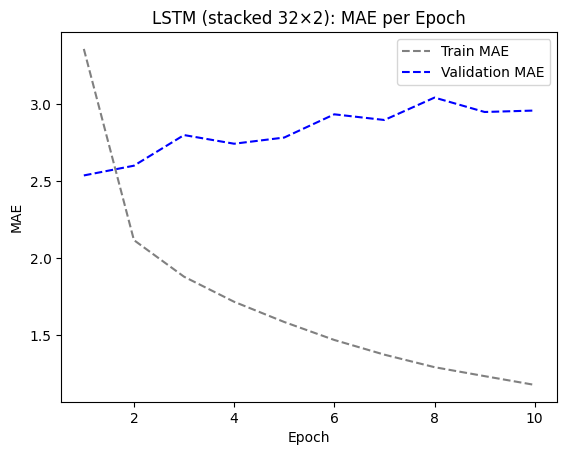

In [53]:
import matplotlib.pyplot as plt
# Plot MAE for the stacked-32 LSTM: training vs validation across epochs
train_mae_32 = hist_lstm_32.history["mae"]
val_mae_32 = hist_lstm_32.history["val_mae"]

epoch_idx = range(1, len(train_mae_32) + 1)
plt.figure()
plt.plot(epoch_idx, train_mae_32, color="grey", linestyle="dashed", label="Train MAE")
plt.plot(epoch_idx, val_mae_32, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("LSTM (stacked 32×2): MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [54]:
# Stacked LSTM (8 units each): a compact two-layer recurrent model
lstm_in_8 = keras.Input(shape=(seq_len, feat_mat.shape[-1]))
h_8 = layers.LSTM(8, return_sequences=True)(lstm_in_8)
h_8 = layers.LSTM(8)(h_8)
lstm_out_8 = layers.Dense(1)(h_8)
lstm_stacked_8 = keras.Model(lstm_in_8, lstm_out_8)

callbacks_lstm_8 = [
    keras.callbacks.ModelCheckpoint("jena_lstm_stacked8.keras", save_best_only=True)
]
lstm_stacked_8.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train for 10 epochs with validation tracking
hist_lstm_8 = lstm_stacked_8.fit(
    train_ds_gen,
    epochs=10,
    validation_data=val_ds_gen,
    callbacks=callbacks_lstm_8
)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 51ms/step - loss: 93.8472 - mae: 7.6699 - val_loss: 35.7897 - val_mae: 4.4789
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 27.6949 - mae: 3.9159 - val_loss: 13.2788 - val_mae: 2.7614
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 12.4073 - mae: 2.7149 - val_loss: 10.1373 - val_mae: 2.4782
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 10.2587 - mae: 2.4990 - val_loss: 9.6058 - val_mae: 2.4111
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 9.6539 - mae: 2.4233 - val_loss: 9.4823 - val_mae: 2.4127
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 9.1993 - mae: 2.3692 - val_loss: 9.6408 - val_mae: 2.4219
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - loss: 8.8657 - mae: 2.3270 - val_loss: 9.6100 - val_mae: 2.4022
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 8.6120 - mae: 2.2932 - val_loss: 9.8609 - val_mae: 2.4203
Epoch 9/10
819/819 ━━━━━━━━━━━━━━

In [55]:
# Reload the best stacked-8 LSTM and report test MAE
best_lstm_8 = keras.models.load_model("jena_lstm_stacked8.keras")
print(f"Test MAE (LSTM stacked, 8 units × 2): {best_lstm_8.evaluate(test_ds_gen)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 10.8315 - mae: 2.5619
Test MAE (LSTM stacked, 8 units × 2): 2.56


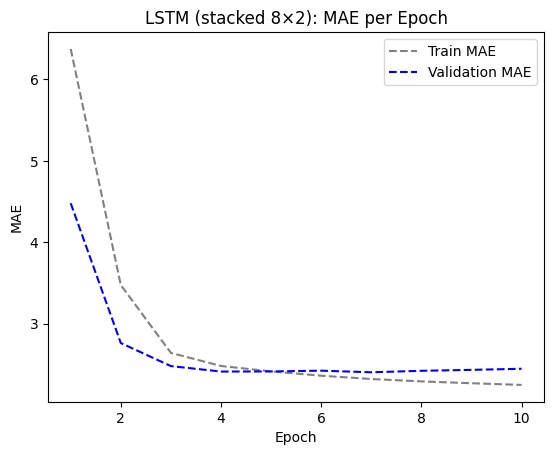

In [56]:
import matplotlib.pyplot as plt
# Track MAE across epochs for the compact stacked-8 LSTM
train_mae_8 = hist_lstm_8.history["mae"]
val_mae_8 = hist_lstm_8.history["val_mae"]

epoch_idx = range(1, len(train_mae_8) + 1)
plt.figure()
plt.plot(epoch_idx, train_mae_8, color="grey", linestyle="dashed", label="Train MAE")
plt.plot(epoch_idx, val_mae_8, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("LSTM (stacked 8×2): MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [57]:
# Stacked LSTM with dropout on recurrent state and post-LSTM activations
lstm_reg_in = keras.Input(shape=(seq_len, feat_mat.shape[-1]))
u = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(lstm_reg_in)
u = layers.LSTM(8, recurrent_dropout=0.5)(u)
u = layers.Dropout(0.5)(u)
lstm_reg_out = layers.Dense(1)(u)
lstm_stacked_dropout = keras.Model(lstm_reg_in, lstm_reg_out)

callbacks_lstm_sd = [
    keras.callbacks.ModelCheckpoint("jena_lstm_stacked_dropout.keras", save_best_only=True)
]
lstm_stacked_dropout.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
hist_lstm_sd = lstm_stacked_dropout.fit(
    train_ds_gen,
    epochs=10,
    validation_data=val_ds_gen,
    callbacks=callbacks_lstm_sd
)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 76ms/step - loss: 105.2125 - mae: 8.2064 - val_loss: 38.4840 - val_mae: 4.6487
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 62s 76ms/step - loss: 38.7033 - mae: 4.6587 - val_loss: 14.2378 - val_mae: 2.7934
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 62s 76ms/step - loss: 25.5103 - mae: 3.8127 - val_loss: 10.9843 - val_mae: 2.5288
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 61s 75ms/step - loss: 22.8501 - mae: 3.6187 - val_loss: 10.2209 - val_mae: 2.4632
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 63s 77ms/step - loss: 21.3589 - mae: 3.5094 - val_loss: 10.4033 - val_mae: 2.4989
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 63s 76ms/step - loss: 20.3171 - mae: 3.4226 - val_loss: 9.8469 - val_mae: 2.4408
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 62s 76ms/step - loss: 19.3961 - mae: 3.3491 - val_loss: 9.3636 - val_mae: 2.3832
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 64s 78ms/step - loss: 18.7955 - mae: 3.3019 - val_loss: 10.3080 - val_mae: 2.4969
Epoch 9/10
819/819 ━━━━━━

In [58]:
# Load the best stacked+dropout LSTM and report test performance
best_lstm_sd = keras.models.load_model("jena_lstm_stacked_dropout.keras")
print(f"Test MAE (Stacked LSTM + dropout): {best_lstm_sd.evaluate(test_ds_gen)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 10.8722 - mae: 2.5705
Test MAE (Stacked LSTM + dropout): 2.57


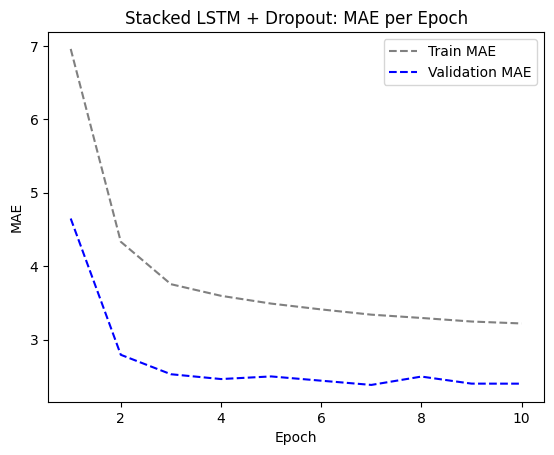

In [59]:
import matplotlib.pyplot as plt
# Plot MAE over epochs for the stacked+dropout LSTM
train_mae_sd = hist_lstm_sd.history["mae"]
val_mae_sd = hist_lstm_sd.history["val_mae"]

epoch_idx = range(1, len(train_mae_sd) + 1)
plt.figure()
plt.plot(epoch_idx, train_mae_sd, color="grey", linestyle="dashed", label="Train MAE")
plt.plot(epoch_idx, val_mae_sd, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Stacked LSTM + Dropout: MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [60]:
# Bidirectional LSTM: read the window forward and backward, then predict one value
inp_bi = keras.Input(shape=(seq_len, feat_mat.shape[-1]))
h_bi = layers.Bidirectional(layers.LSTM(16))(inp_bi)
out_bi = layers.Dense(1)(h_bi)
bi_lstm = keras.Model(inp_bi, out_bi)

callbacks_bi = [
    keras.callbacks.ModelCheckpoint("jena_bidir_lstm.keras", save_best_only=True)
]

bi_lstm.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
hist_bi = bi_lstm.fit(
    train_ds_gen,
    epochs=5,
    validation_data=val_ds_gen,
    callbacks=callbacks_bi
)

Epoch 1/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - loss: 53.1638 - mae: 5.3544 - val_loss: 10.6337 - val_mae: 2.5209
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 10.0291 - mae: 2.4759 - val_loss: 9.2861 - val_mae: 2.3646
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 8.8726 - mae: 2.3191 - val_loss: 9.6548 - val_mae: 2.4037
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 8.2038 - mae: 2.2304 - val_loss: 9.5361 - val_mae: 2.3975
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 7.8212 - mae: 2.1760 - val_loss: 9.6076 - val_mae: 2.3938


In [61]:
# Reload the best bidirectional LSTM and print its test MAE
best_bilstm = keras.models.load_model("jena_bidir_lstm.keras")
print(f"Test MAE (BiLSTM): {best_bilstm.evaluate(test_ds_gen)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 11.1989 - mae: 2.6014
Test MAE (BiLSTM): 2.60


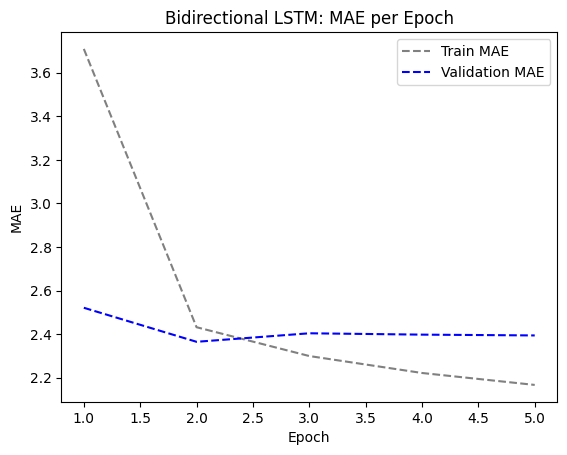

In [62]:
import matplotlib.pyplot as plt
# Plot training vs validation MAE for the bidirectional LSTM
bi_train_mae = hist_bi.history["mae"]
bi_val_mae = hist_bi.history["val_mae"]

epoch_idx = range(1, len(bi_train_mae) + 1)
plt.figure()
plt.plot(epoch_idx, bi_train_mae, color="grey", linestyle="dashed", label="Train MAE")
plt.plot(epoch_idx, bi_val_mae, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Bidirectional LSTM: MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [63]:
# Hybrid: small 1D CNN front-end feeding an LSTM head
conv_lstm_in = keras.Input(shape=(seq_len, feat_mat.shape[-1]))
g = layers.Conv1D(64, 3, activation="relu")(conv_lstm_in)
g = layers.MaxPooling1D(3)(g)
g = layers.Conv1D(128, 3, activation="relu")(g)
g = layers.GlobalMaxPooling1D()(g)
g = layers.Reshape((-1, 128))(g)  # make it 3D again for the LSTM
g = layers.LSTM(16)(g)
conv_lstm_out = layers.Dense(1)(g)
conv_lstm = keras.Model(conv_lstm_in, conv_lstm_out)

conv_lstm.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks_conv_lstm = [
    keras.callbacks.ModelCheckpoint("jena_conv_lstm.keras", save_best_only=True)
]

hist_conv_lstm = conv_lstm.fit(
    train_ds_gen, epochs=5, validation_data=val_ds_gen, callbacks=callbacks_conv_lstm
)

Epoch 1/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 69.1928 - mae: 6.3940 - val_loss: 25.7801 - val_mae: 3.9179
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 19.0669 - mae: 3.3594 - val_loss: 25.1899 - val_mae: 4.0699
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 14.8154 - mae: 2.9956 - val_loss: 22.5113 - val_mae: 3.7431
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 12.9711 - mae: 2.7976 - val_loss: 22.6440 - val_mae: 3.7984
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 11.8861 - mae: 2.6663 - val_loss: 22.9317 - val_mae: 3.8619


In [64]:
# Reload the best hybrid Conv+LSTM and report its test MAE
best_conv_lstm = keras.models.load_model("jena_conv_lstm.keras")
print(f"Test MAE (Conv+LSTM): {best_conv_lstm.evaluate(test_ds_gen)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 22.8836 - mae: 3.7631
Test MAE (Conv+LSTM): 3.77


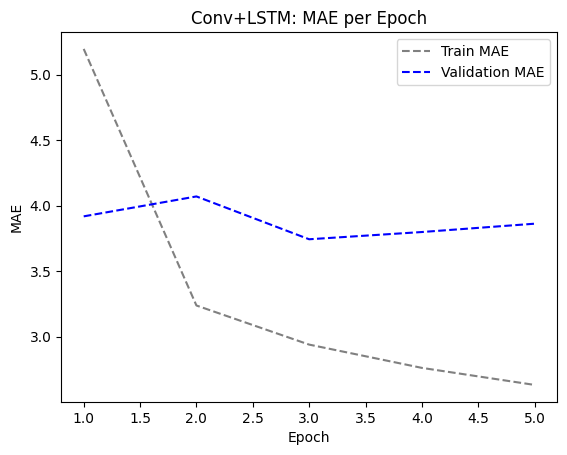

In [65]:
import matplotlib.pyplot as plt
# Show MAE trends across epochs for the Conv+LSTM run
train_mae_hybrid = hist_conv_lstm.history["mae"]
val_mae_hybrid = hist_conv_lstm.history["val_mae"]

epoch_idx = range(1, len(train_mae_hybrid) + 1)
plt.figure()
plt.plot(epoch_idx, train_mae_hybrid, color="grey", linestyle="dashed", label="Train MAE")
plt.plot(epoch_idx, val_mae_hybrid, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Conv+LSTM: MAE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

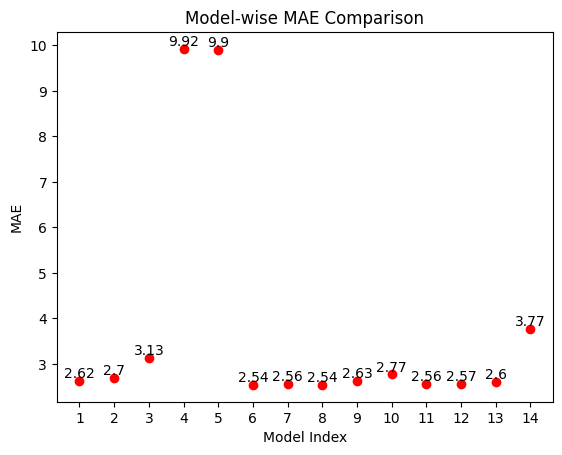

In [68]:
# Common sense baseline: predict next-day temperature equals current value (last value)
# Basic dense model: flattened window → small hidden layer → single output
# 1D CNN: stacked conv and pooling, global pooling, linear head
# Simple RNN: single recurrent layer over variable-length sequences
# Stacked Simple RNN: multiple SimpleRNN layers with return_sequences on intermediates
# GRU: single gated recurrent unit over the fixed window
# LSTM simple: single LSTM layer plus linear output
# LSTM with dropout: recurrent_dropout inside LSTM and Dropout after it
# Stacked LSTM 16×2: two LSTM layers, 16 units each
# Stacked LSTM 32×2: two LSTM layers, 32 units each
# Stacked LSTM 8×2: two LSTM layers, 8 units each
# Stacked LSTM with dropout: stacked LSTMs with recurrent and standard dropout
# Bidirectional LSTM: LSTM processes the window forward and backward
# Conv plus LSTM hybrid: small CNN front end feeding an LSTM head

# Summary chart: compare MAE across 14 configured baselines and neural models
model_ids = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
mae_scores = (2.62, 2.7, 3.13, 9.92, 9.9, 2.54, 2.56, 2.54, 2.63, 2.77, 2.56, 2.57, 2.60, 3.77)

# Scatter the MAE per model index; annotate each point with its value
plt.scatter(model_ids, mae_scores, color="red")
plt.title("Model-wise MAE Comparison")
plt.xlabel("Model Index")
plt.ylabel("MAE")

for xi, yi in zip(model_ids, mae_scores):
    plt.text(xi, yi, yi, va="bottom", ha="center")

plt.show()